In [20]:
# Import
import pandas as pd
import darts
from darts import TimeSeries
from darts.models import ExponentialSmoothing, ARIMA, Prophet
import matplotlib.pyplot as plt
from darts.utils.utils import SeasonalityMode
from darts.utils.statistics import plot_acf, plot_pacf, check_seasonality, extract_trend_and_seasonality, ModelMode, remove_trend, remove_from_series, stationarity_tests
import glob 
import os
from darts.utils.missing_values import fill_missing_values
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
import sys, os
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import STL
from pyod.models.auto_encoder import AutoEncoder
from sklearn.metrics import f1_score

In [2]:
# Merging all files and making the dataframe
# df = pd.concat(map(pd.read_csv, glob.glob(os.path.join("./data" , "*.csv"))), ignore_index= True)
df = pd.read_csv('data/0.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.set_index('timestamp')
df = df.asfreq(freq='T')

In [3]:
df_hourly = df.resample('H').mean().interpolate()

In [4]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df_hourly, value_cols='value')
# Set aside the last 20 percent of ts as a validation series
train, val = series[:-round(len(df_hourly) / 5)], series[-round(len(df_hourly) / 5):]

### IsolationForest

In [6]:
outliers_fraction = float(.01)
scaler = StandardScaler()
dataframe_style = series.pd_dataframe() 
np_scaled = scaler.fit_transform(dataframe_style.value.to_numpy().reshape(-1, 1))
data = pd.DataFrame(np_scaled)

#### Train isolation forest

In [7]:
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)
dataframe_style['anomaly'] = model.predict(data)

#### Visualization

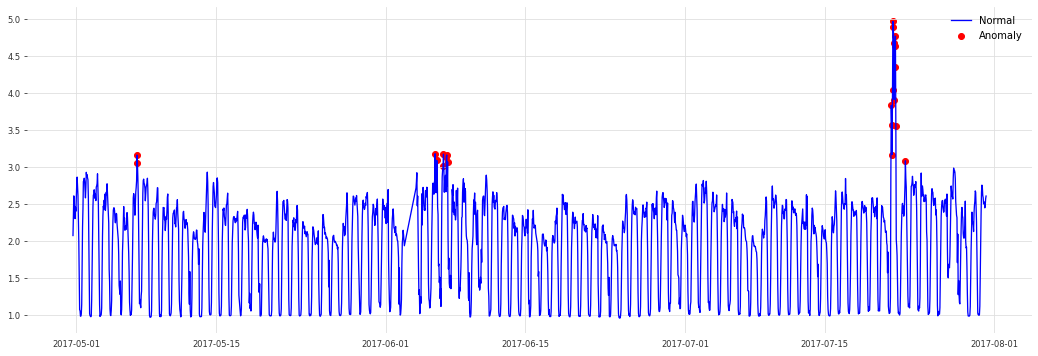

In [8]:
fig, ax = plt.subplots(figsize=(18,6))
a = dataframe_style.loc[dataframe_style['anomaly'] == -1, ['value']] #anomaly
ax.plot(dataframe_style.index, dataframe_style['value'], color='blue', label = 'Normal')
ax.scatter(a.index,a['value'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

### Autoencoder

In [14]:
clf = AutoEncoder(hidden_neurons =[1, 2, 2, 1])
clf.fit(data)

2022-09-07 16:43:05.541451: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-07 16:43:05.542259: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
 dropout_1 (Dropout)         (None, 1)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
 dropout_2 (Dropout)         (None, 1)                 0         
                                              

2022-09-07 16:43:06.508015: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-07 16:43:06.906309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - 4s 18ms/step - loss: 1.3120 - val_loss: 1.2968
Epoch 2/100
 1/62 [..............................] - ETA: 0s - loss: 1.4147

2022-09-07 16:43:10.578461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - 1s 12ms/step - loss: 1.2694 - val_loss: 1.2769
Epoch 3/100
62/62 [==============================] - 1s 12ms/step - loss: 1.2463 - val_loss: 1.2581
Epoch 4/100
62/62 [==============================] - 1s 12ms/step - loss: 1.2304 - val_loss: 1.2405
Epoch 5/100
62/62 [==============================] - 1s 13ms/step - loss: 1.2150 - val_loss: 1.2244
Epoch 6/100
62/62 [==============================] - 1s 12ms/step - loss: 1.2021 - val_loss: 1.2096
Epoch 7/100
62/62 [==============================] - 1s 13ms/step - loss: 1.1880 - val_loss: 1.1952
Epoch 8/100
62/62 [==============================] - 1s 13ms/step - loss: 1.1762 - val_loss: 1.1822
Epoch 9/100
62/62 [==============================] - 1s 13ms/step - loss: 1.1669 - val_loss: 1.1699
Epoch 10/100
62/62 [==============================] - 1s 12ms/step - loss: 1.1552 - val_loss: 1.1582
Epoch 11/100
62/62 [==============================] - 1s 12ms/step - loss: 1.1470 - val_loss: 1.1473
Epoch 12/1

2022-09-07 16:44:23.808673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[1, 2, 2, 1],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x2a6435790>, optimizer='adam',
      output_activation='sigmoid', preprocessing=True, random_state=None,
      validation_size=0.1, verbose=1)

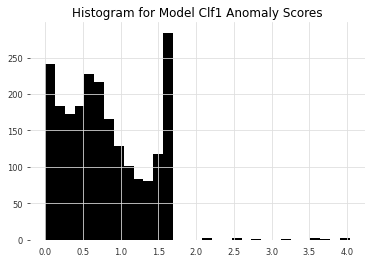

In [16]:
# Get the outlier scores for the train data
y_train_scores = clf.decision_scores_
# Predict the anomaly scores
y_test_scores = clf.decision_function(data)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
 
# Plot it!
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto') 
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

In [42]:
df_test = data.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<2, 0, 1)
df_test['cluster'].value_counts()
df_test.groupby('cluster').mean()

,0,score
cluster,,
0,-0.019210,0.779748
1,3.817611,3.107688


In [43]:
f1_score(df_hourly['label'].values.astype(int), df_test['cluster'].values)

0.16